In [27]:
import pandas as pd
import numpy as np
import wandb
import accelerate
import bitsandbytes
import datasets
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import tokenizers
import torch
import transformers
import trl
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import TrainingArguments, set_seed, get_constant_schedule
from trl import SFTTrainer, setup_chat_format, DataCollatorForCompletionOnlyLM
from datasets import load_dataset
import uuid
from datasets import DatasetDict, Dataset

[2024-07-10 10:25:34,638] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.2
 [WARNING]  please install triton==1.0.0 if you want to use sparse attention


In [3]:
df_without_sys = pd.read_csv("eval_file_without_system_prompt.csv")
df_with_sys = pd.read_csv("eval_file_with_system_prompt.csv")

In [4]:
df_without_sys.columns

Index(['input', 'output', 'instruction', 'messages', 'original_ouput',
       'modified_output', 'not_fine_tuned_model_output'],
      dtype='object')

In [5]:
df_with_sys.columns

Index(['input', 'output', 'instruction', 'messages', 'input_with_sys_prompt',
       'original_ouput_with_sys_prompt', 'modified_output_with_sys_prompt'],
      dtype='object')

In [6]:
combined_df = pd.concat([df_without_sys, df_with_sys[['input_with_sys_prompt', 'original_ouput_with_sys_prompt', 'modified_output_with_sys_prompt']]], axis=1)

In [7]:
# Rename columns
combined_df = combined_df.rename(columns={
    'original_ouput': 'original_ouput_without_sys_prompt',
    'modified_output': 'modified_output_without_sys_prompt',
    'output' : "Human_output",
})

In [8]:
combined_df.to_csv("combined_file_with_and_without_sys_prompt.csv", index = False)
combined_df.to_pickle("combined_file_with_and_without_sys_prompt.pkl")

In [9]:
combined_df.columns

Index(['input', 'Human_output', 'instruction', 'messages',
       'original_ouput_without_sys_prompt',
       'modified_output_without_sys_prompt', 'not_fine_tuned_model_output',
       'input_with_sys_prompt', 'original_ouput_with_sys_prompt',
       'modified_output_with_sys_prompt'],
      dtype='object')

In [10]:

combined_df.isnull().sum()

input                                  0
Human_output                          12
instruction                            0
messages                               0
original_ouput_without_sys_prompt      0
modified_output_without_sys_prompt    30
not_fine_tuned_model_output            0
input_with_sys_prompt                  0
original_ouput_with_sys_prompt         0
modified_output_with_sys_prompt       34
dtype: int64

In [11]:
combined_df.shape

(3422, 10)

In [12]:
for input in combined_df.input:
    print(f"\n{input}")


Has anyone compared an in-person Tax Advisor to software like Turbo Tax?

Understanding the phrase “afford to lose” better

What expenses do most people not prepare for that turn into “emergencies” but are not covered by an Emergency Fund?

Layman's guide to getting started with Forex (foreign exchange trading)?

How to determine how much to charge your business for rent (in your house)?

Should I pay more than 20% down on a home?

What are the best software tools for personal finance?

Ways to save for child's college education where one need not commit to set contributions? [duplicate]

How can one get their FICO/credit scores for free? (really free)

what is difference between stock and dividend?

Automatic investments for cheap

What one bit of financial advice do you wish you could've given yourself five years ago?

Why invest for the long-term rather than buy and sell for quick, big gains?

Giving kids annual tax free gift of $28,000

Are there any banks in Europe that I can hav

In [13]:
combined_df.dropna(inplace=True)

In [26]:
combined_df.columns

Index(['input', 'Human_output', 'instruction', 'messages',
       'original_ouput_without_sys_prompt',
       'modified_output_without_sys_prompt', 'not_fine_tuned_model_output',
       'input_with_sys_prompt', 'original_ouput_with_sys_prompt',
       'modified_output_with_sys_prompt'],
      dtype='object')

In [28]:
tokenizer = AutoTokenizer.from_pretrained("/home/trkosire/LLM_RESEARCH/Finance/out_OpenELM-270M_LR-5e-05_OA_bf130067-0855-427c-ba89-f63b91981af7/checkpoint-3250")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


 average_of_human_output_token_lengths: 258.2004 

 median_of_human_output_token_lengths: 195.0000 

 mode_of_human_output_token_lengths: (173, 19) 


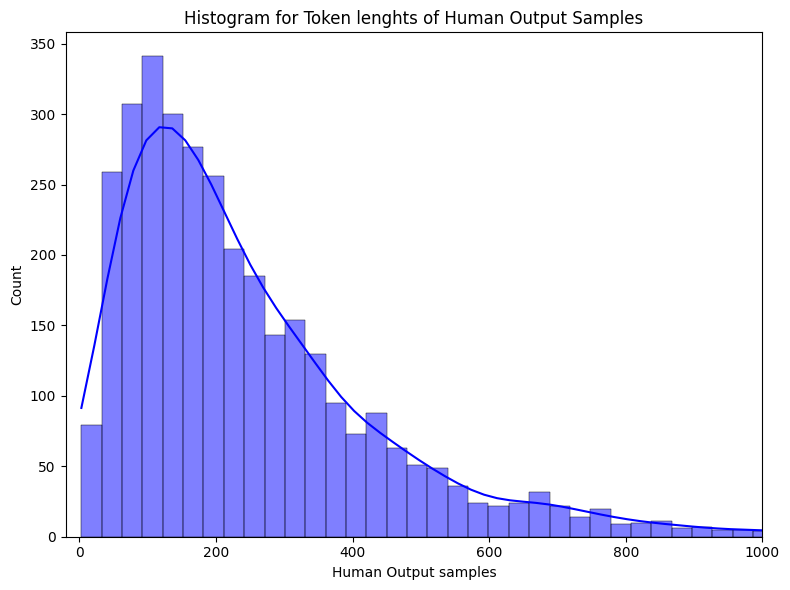

In [160]:

human_output_token_lengths = combined_df['Human_output'].apply(lambda x: len(tokenizer.tokenize(x)))

average_of_human_output_token_lengths = human_output_token_lengths.mean() 

median_of_human_output_token_lengths  = human_output_token_lengths.median()

counter = Counter(human_output_token_lengths)
mode_of_human_output_token_lengths = counter.most_common()[0]


print(f"\n average_of_human_output_token_lengths: {average_of_human_output_token_lengths:.4f} ")
print(f"\n median_of_human_output_token_lengths: {median_of_human_output_token_lengths:.4f} ")
print(f"\n mode_of_human_output_token_lengths: {mode_of_human_output_token_lengths} ")

plt.figure(figsize=(8,6))
sns.histplot(human_output_token_lengths, kde=True, line_kws= {'color' : 'black'}, color='blue' )
plt.xlim(-20, 1000)
plt.xlabel("Human Output samples")
plt.title("Histogram for Token lenghts of Human Output Samples")
plt.tight_layout()
plt.show()


 average_of_not_fine_tuned_model_output_token_lengths: 250.0322 

 median_of_not_fine_tuned_model_output_token_lengths: 251.0000 

 mode_of_not_fine_tuned_model_output_token_lengths: (251, 2623) 


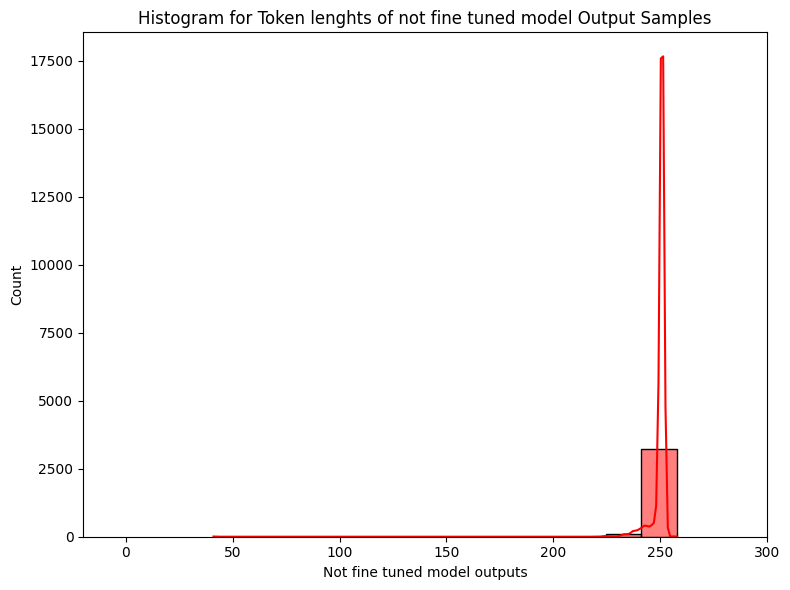

In [161]:

not_fine_tuned_model_output_token_lengths = combined_df['not_fine_tuned_model_output'].apply(lambda x: len(tokenizer.tokenize(x)))

average_of_not_fine_tuned_model_output_token_lengths = not_fine_tuned_model_output_token_lengths.mean() 

median_of_not_fine_tuned_model_output_token_lengths  = not_fine_tuned_model_output_token_lengths.median()

counter = Counter(not_fine_tuned_model_output_token_lengths)
mode_of_not_fine_tuned_model_output_token_lengths = counter.most_common()[0]


print(f"\n average_of_not_fine_tuned_model_output_token_lengths: {average_of_not_fine_tuned_model_output_token_lengths:.4f} ")
print(f"\n median_of_not_fine_tuned_model_output_token_lengths: {median_of_not_fine_tuned_model_output_token_lengths:.4f} ")
print(f"\n mode_of_not_fine_tuned_model_output_token_lengths: {mode_of_not_fine_tuned_model_output_token_lengths} ")

plt.figure(figsize=(8,6))
sns.histplot(not_fine_tuned_model_output_token_lengths, kde=True, line_kws= {'color' : 'black'}, color='red' )
plt.xlim(-20, 300)
plt.xlabel("Not fine tuned model outputs")
plt.title("Histogram for Token lenghts of not fine tuned model Output Samples")
plt.tight_layout()
plt.show()


 average_of_not_fine_tuned_model_output_token_lengths: 87.2634 

 median_of_not_fine_tuned_model_output_token_lengths: 72.0000 

 mode_of_not_fine_tuned_model_output_token_lengths: (250, 93) 


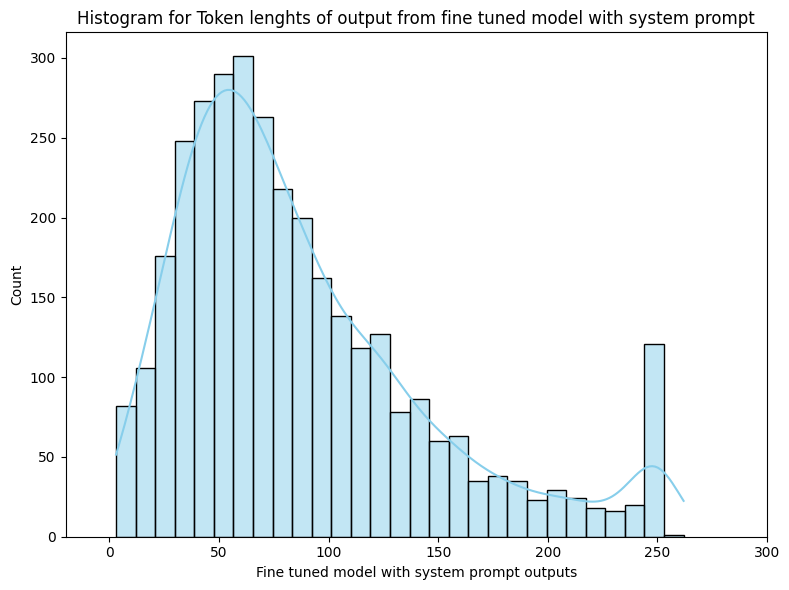

In [162]:

fine_tuned_model_with_sys_output_token_lengths = combined_df['modified_output_with_sys_prompt'].apply(lambda x: len(tokenizer.tokenize(x)))

average_of_fine_tuned_model_with_sys_output_token_lengths = fine_tuned_model_with_sys_output_token_lengths.mean() 

median_of_fine_tuned_model_with_sys_output_token_lengths  = fine_tuned_model_with_sys_output_token_lengths.median()

counter = Counter(fine_tuned_model_with_sys_output_token_lengths)
mode_of_fine_tuned_model_with_sys_output_token_lengths = counter.most_common()[0]


print(f"\n average_of_not_fine_tuned_model_output_token_lengths: {average_of_fine_tuned_model_with_sys_output_token_lengths:.4f} ")
print(f"\n median_of_not_fine_tuned_model_output_token_lengths: {median_of_fine_tuned_model_with_sys_output_token_lengths:.4f} ")
print(f"\n mode_of_not_fine_tuned_model_output_token_lengths: {mode_of_fine_tuned_model_with_sys_output_token_lengths} ")

plt.figure(figsize=(8,6))
sns.histplot(fine_tuned_model_with_sys_output_token_lengths, kde=True, line_kws= {'color' : 'black'}, color='skyblue' )
plt.xlim(-20, 300)
plt.xlabel("Fine tuned model with system prompt outputs")
plt.title("Histogram for Token lenghts of output from fine tuned model with system prompt")
plt.tight_layout()
plt.show()


 average_of_not_fine_tuned_model_output_token_lengths: 86.7399 

 median_of_not_fine_tuned_model_output_token_lengths: 72.0000 

 mode_of_not_fine_tuned_model_output_token_lengths: (250, 102) 


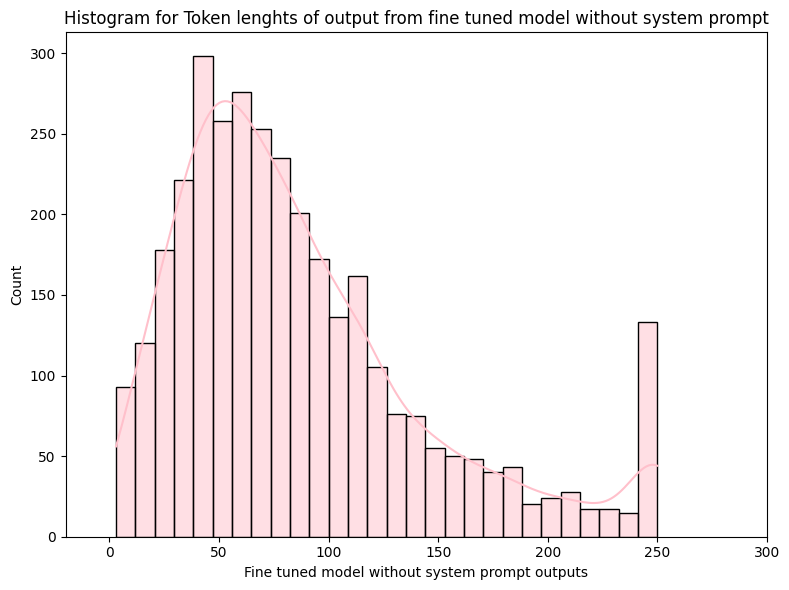

In [166]:

fine_tuned_model_without_sys_output_token_lengths = combined_df['modified_output_without_sys_prompt'].apply(lambda x: len(tokenizer.tokenize(x)))

average_of_fine_tuned_model_without_sys_output_token_lengths = fine_tuned_model_without_sys_output_token_lengths.mean() 

median_of_fine_tuned_model_without_sys_output_token_lengths  = fine_tuned_model_without_sys_output_token_lengths.median()

counter = Counter(fine_tuned_model_without_sys_output_token_lengths)
mode_of_fine_tuned_model_without_sys_output_token_lengths = counter.most_common()[0]


print(f"\n average_of_not_fine_tuned_model_output_token_lengths: {average_of_fine_tuned_model_without_sys_output_token_lengths:.4f} ")
print(f"\n median_of_not_fine_tuned_model_output_token_lengths: {median_of_fine_tuned_model_without_sys_output_token_lengths:.4f} ")
print(f"\n mode_of_not_fine_tuned_model_output_token_lengths: {mode_of_fine_tuned_model_without_sys_output_token_lengths} ")

plt.figure(figsize=(8,6))
sns.histplot(fine_tuned_model_without_sys_output_token_lengths, kde=True, line_kws= {'color' : 'black'}, color='pink' )
plt.xlim(-20, 300)
plt.xlabel("Fine tuned model without system prompt outputs")
plt.title("Histogram for Token lenghts of output from fine tuned model without system prompt")
plt.tight_layout()
plt.show()

In [152]:
combined_df.columns

Index(['input', 'Human_output', 'instruction', 'messages',
       'original_ouput_without_sys_prompt',
       'modified_output_without_sys_prompt', 'not_fine_tuned_model_output',
       'input_with_sys_prompt', 'original_ouput_with_sys_prompt',
       'modified_output_with_sys_prompt'],
      dtype='object')

In [15]:
np.random.seed(7)

sample_10_df = combined_df.sample(n=10)
sample_10_df = sample_10_df.sample(frac = 1)
# sample_10_df.to_csv("10_sample_file.csv", index=False)

remanining_df = combined_df.loc[~combined_df.index.isin(sample_10_df.index)]

sample_100_df = remanining_df.sample(n= 100)
sample_100_df = sample_100_df.sample(frac = 1)


In [16]:
sample_10_df.columns

Index(['input', 'Human_output', 'instruction', 'messages',
       'original_ouput_without_sys_prompt',
       'modified_output_without_sys_prompt', 'not_fine_tuned_model_output',
       'input_with_sys_prompt', 'original_ouput_with_sys_prompt',
       'modified_output_with_sys_prompt'],
      dtype='object')

In [35]:
sample_10_df = sample_10_df[['input', 'modified_output_with_sys_prompt']]
sample_100_df = sample_100_df[['input', 'modified_output_with_sys_prompt']]

sample_10_df.rename(columns={"input": "Question", "modified_output_with_sys_prompt": "Answer"}, inplace=True)
sample_100_df.rename(columns={"input": "Question", "modified_output_with_sys_prompt": "Answer"}, inplace=True)

sample_10_df['Rating'] = " "
sample_100_df['Rating'] = " " 


In [36]:
sample_10_df

,Question,Answer,Rating
1061,How to safely earn interest on business profit...,"As @Chris_Penn pointed out, you should not do ...",
2230,What is the Difference between Life Insurance ...,Insurance companies make money when you purcha...,
919,Living in my own rental property,You may want to hire an accountant or CPA to d...,
3271,I have about 20 000 usd. How can invest them t...,"I don't know what you are talking about, but a...",
287,"Is this mortgage advice good, or is it hooey?","This is a good question to ask yourself: ""Am I...",
2137,Short Term Capital Gains tax vs. IRA Withdrawa...,"In the end you are still taxed on your income,...",
970,Where do expense ratios show up on my statement?,The expense ratio is calculated as the ratio o...,
443,Is Cost of Living overstated?,"In the end the question is akin to this one, b...",
3176,"Buying an option in the money, at the money, o...",You should use a stop loss to reduce the chanc...,
1271,Why doesn't Japan just divide the Yen by 100?,"I know it would be easier to just say ""100"" in...",


In [39]:
sample_100_df


,Question,Answer,Rating
198,Should I continue to invest in an S&P 500 inde...,I would argue that it makes sense to sell some...,
3392,"File bankruptcy, consolidate, or other options?","You are not a failure. In fact, the bankruptc...",
1895,How do you translate a per year salary into a ...,You should take a look at the W4 form. If you ...,
859,Quote driven and order driven financial markets,I would not say that the quote driven markets ...,
2319,"If the U.S. defaults on its debt, what will ha...","I would expect that if they have defaulted, th...",
...,...,...,...
630,Do stocks give you more control over your fina...,You can have some level of control over your f...,
2079,Why do people buy insurance even if they have ...,One of the most significant reasons is that th...,
633,Why does it take two weeks (from ex-date) for ...,I'm sure there are plenty of other answers to ...,
989,Buying insurance (extended warranty or guarant...,You are making assumptions that the product yo...,


In [40]:
sample_10_df.to_csv("10_sample_file.csv", index=False)
sample_100_df.to_csv("100_sample_file.csv", index=False)